In [146]:
import numpy as np
import cvxpy as cp
import numpy as np

g = 9.81
l = 1.
I_a = 0.5
m_a = 1.
theta_1_real = l*g*m_a/(2.*I_a)
theta_2_real = 1/I_a



theta_real = np.array([[theta_1_real],[theta_2_real]])
A = np.array([[0,1],[0,0]])
C = np.array([[1.,0.]])
Psi = np.array([[0],[0]])
#dt = 0.0001

#Defining variable
dt = 0.01
N = int(35./dt + 1)
t = np.linspace(0,35,N)
x = np.zeros([2,1,N])
u = np.zeros([1,1,N])
z = np.zeros([2,1,N])
y = np.zeros([1,1,N])
p = np.zeros([1,1,N])
theta_real = np.zeros([2,1,N]) 
theta_est = np.zeros([2,1,N])

## Initial Condition
theta_est[:,:,0] = np.array([[5.0],[1.0]])
x[:,:,0] = np.array([[1.0],[1.0]])
z[:,:,0] = np.array([[0.0],[0.0]])

## Observer Design
L = 2.
rho_theta = 6.5
A = np.array([[0,1],[0,0]])
C = np.array([[1.,0.]])


S_x = cp.Variable((2, 2), PSD=True)

LMI = S_x + A.T@S_x + S_x@A-C.T@C
cons1 = LMI == 0
cons2 = S_x == S_x.T
cons3 = S_x >> 0

prob = cp.Problem(cp.Minimize(0.1),constraints=[cons1, cons2, cons3])
prob.solve()
Sx = S_x.value

## Observer Hyperparameter
Delta_L = np.diag([L,L**2])

## Observer variable
S_theta = np.zeros([2,2,N])
S_theta[:,:,0] = np.array([[0.1,1.],[0.5,0.7]])
AA = np.zeros([2,2,N])

for i in range(N-1):
    u[:,:,i] = 5.*(np.sin(5.*t[i])+np.cos(20.*t[i]))
    p[:,:,i] = 0.1*np.sin(0.5*t[i])
    if t[i]<10.:
        theta_1 = 9.81
        theta_2 = 2.00
    if t[i]>10. and t[i]<20.:
        theta_1 = 6.86
        theta_2 = 2.00
    if t[i]>20.:
        theta_1 = 6.86
        theta_2 = 1.42
    theta_real[:,:,i] = np.array([[theta_1],[theta_2]])
    ## Dynamic Modeling
    u[:,:,i] = 5.*(np.sin(5.*t[i])+np.cos(20.*t[i]))
    r = np.random.normal(0, 0.035, 1)[0]
    y[:,:,i] = np.matmul(C,x[:,:,i]) + r
    Phi = np.array([[0.,0.],[-np.sin(y[:,:,i]),u[:,:,i]]], dtype=float)
    #print(Phi)
    x[:,:,i+1] = x[:,:,i] + dt*((A@x[:,:,i])+Psi+(Phi@theta_real[:,:,i]))
    x1 = x[0,0,i]
    z1 = z[0,0,i]
    e1 = x1 - z1
    x2 = x[1,0,i]
    z2 = z[1,0,i]
    e2 = x2 - z2
    #e2 = 0.
    #T_tilde = np.array([[1.,0.],[0.,2.*np.sqrt(np.absolute(e1+r))]], dtype=float)
    Phi_e = (2*np.sqrt(np.absolute(e1+r))/L**2)*Phi
    
    S_theta[:,:,i+1] = S_theta[:,:,i] + dt*((L/(2*np.sqrt(np.absolute(e1+r))))*(-(2*np.sqrt(np.absolute(e1+r))/L)*rho_theta*S_theta[:,:,i] + AA[:,:,i].T@C.T@C@AA[:,:,i]))
    AA[:,:,i+1] = AA[:,:,i] + dt*((L/(2*np.sqrt(np.absolute(e1+r))))*((A - np.linalg.inv(Sx)@C.T@C)@AA[:,:,i] + Phi_e))
    zetha1 = np.sqrt(np.absolute(e1+r))*np.sign(e1+r)
    zetha2 = e2/L
    zetha = np.array([[zetha1],[zetha2]])
    theta_est[:,:,i+1] = theta_est[:,:,i] + dt*((L/(2*np.sqrt(np.absolute(e1+r))))*(np.linalg.inv(S_theta[:,:,i])@AA[:,:,i].T@C.T@C@zetha))
    z[:,:,i+1] = z[:,:,i] + dt*(A@z[:,:,i]+Psi+Phi@theta_est[:,:,i] + Delta_L@np.diag([np.sqrt(np.absolute(e1+r))*np.sign(e1+r),0.5*np.sign(e1+r)])@(np.linalg.inv(Sx)@C.T+AA[:,:,i]@np.linalg.inv(S_theta[:,:,i])@AA[:,:,i].T@C.T))
    
    

<ipython-input-146-f7000327b073>:80: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  Phi = np.array([[0.,0.],[-np.sin(y[:,:,i]),u[:,:,i]]], dtype=float)


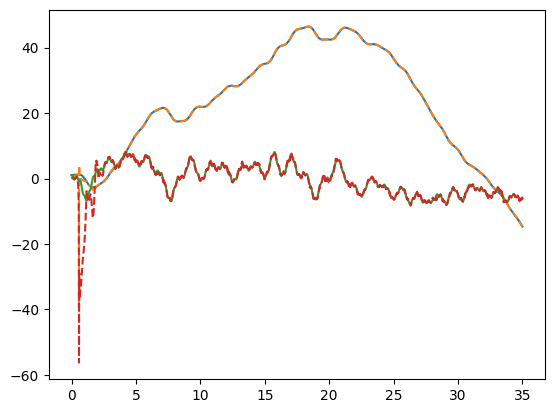

In [147]:
import matplotlib.pyplot as plt
plt.plot(t,x[0,0,:])
plt.plot(t,z[0,0,:],'--')

plt.plot(t,x[1,0,:])
plt.plot(t,z[1,0,:],'--')
plt.show()

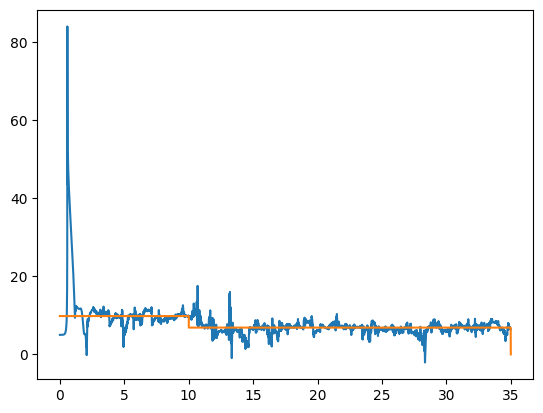

In [149]:

plt.plot(t,theta_est[0,0,:])
plt.plot(t,theta_real[0,0,:])
#plt.plot(t,theta_est[1,0,:])
plt.show()

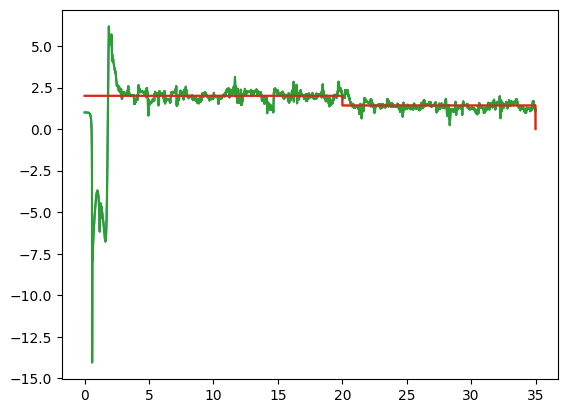

In [151]:
plt.plot(t,theta_est[1,0,:])
plt.plot(t,theta_real[1,0,:])
plt.show()